## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import re
import time

##  Download NLTK resources

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
print("📚 Starting ATS Score ML Model Training with resume.csv")

📚 Starting ATS Score ML Model Training with resume.csv


## Load Data Set

In [4]:
data = pd.read_csv("/content/drive/MyDrive/ResumeNova/Resume_Data/Resume/Resume/Resume.csv")
data.sample(10)

,ID,Resume_str,Resume_html,Category
813,27974588,GROUP FITNESS INSTRUCTOR Summar...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS
714,10480456,"DIRECTOR, NEW PRODUCT RESEARCH AND R&...","<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE
1386,65373280,EXECUTIVE CHEF Summary Mo...,"<div class=""fontsize fontface vmargins hmargin...",CHEF
1956,13907230,GENERAL CONSTRUCTION INTERN Obj...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
1018,26994282,SALES Professional Summary T...,"<div class=""fontsize fontface vmargins hmargin...",SALES
1460,57262959,TRAINING & DEVELOPMENT SPECIALIST/HR ...,"<div class=""fontsize fontface vmargins hmargin...",CHEF
2420,10945968,GLOBAL IT PROJECT MANAGER Summa...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
902,14107571,FLIGHT ATTENDANT Summary Fo...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS
2372,10176815,AVIATION ELECTRONICS TECHNICIAN ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
104,18731098,SENIOR HR MANAGER Professiona...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [5]:
print(f"Shape: \n{data.shape}")

Shape: 
(2484, 4)


In [6]:
print((f"Columns: {list(data.columns)}"))

Columns: ['ID', 'Resume_str', 'Resume_html', 'Category']


In [7]:
print(f"Data Types: \n{data.dtypes}")

Data Types: 
ID              int64
Resume_str     object
Resume_html    object
Category       object
dtype: object


In [8]:
print(f"Check null value: \n{data.isnull()}\n\n\nTotal number of null value:\n{data.isnull().sum()}")


Check null value: 
         ID  Resume_str  Resume_html  Category
0     False       False        False     False
1     False       False        False     False
2     False       False        False     False
3     False       False        False     False
4     False       False        False     False
...     ...         ...          ...       ...
2479  False       False        False     False
2480  False       False        False     False
2481  False       False        False     False
2482  False       False        False     False
2483  False       False        False     False

[2484 rows x 4 columns]


Total number of null value:
ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64


In [9]:
print(f"Overall Info: \n{data.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB
Overall Info: 
None


In [10]:
category=data["Category"].unique()
print(category)
print(f"\nTotal Category: {len(category)}")

['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'CHEF' 'FINANCE' 'APPAREL'
 'ENGINEERING' 'ACCOUNTANT' 'CONSTRUCTION' 'PUBLIC-RELATIONS' 'BANKING'
 'ARTS' 'AVIATION']

Total Category: 24


In [11]:
print(data["Category"].value_counts())

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


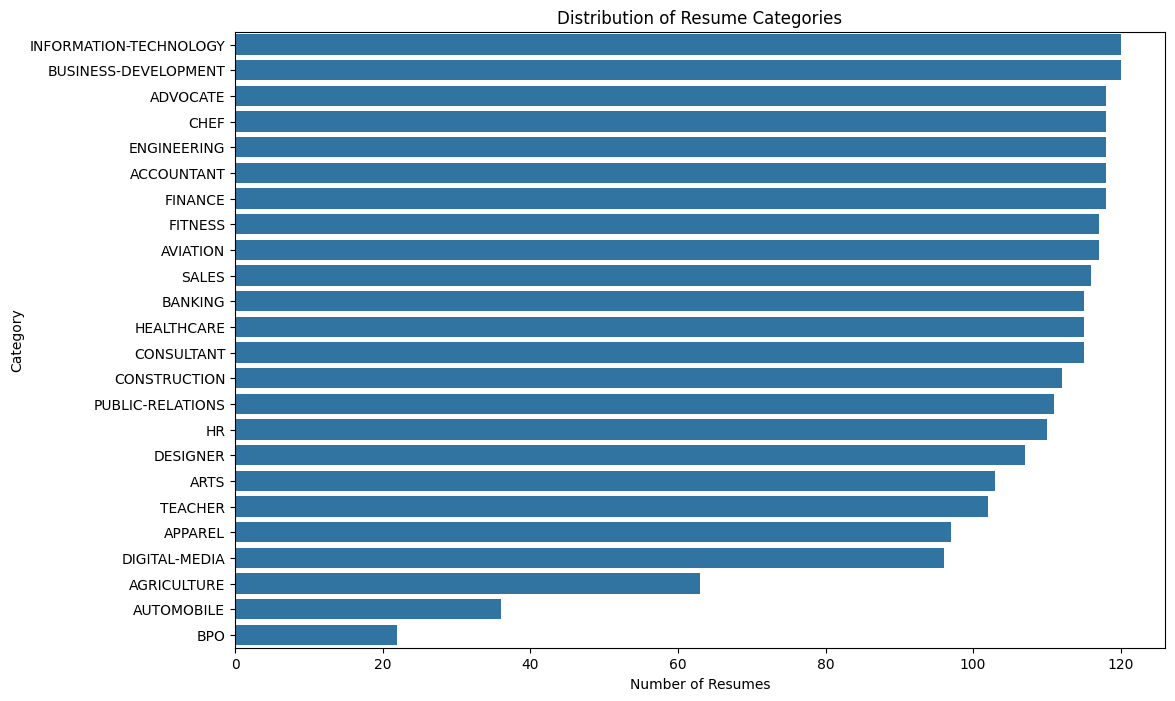

In [12]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Category', data=data, order = data['Category'].value_counts().index)
plt.title('Distribution of Resume Categories')
plt.xlabel('Number of Resumes')
plt.ylabel('Category')
plt.show()

## Create Job Descriptions for each Category for filteration

In [13]:
def create_category_job_descriptions():
    """Create realistic job descriptions for each category"""

    jd_templates = {
        'Information-Technology': """Software Developer position requiring programming skills in Python, Java, or JavaScript.
        Experience with databases, cloud platforms (AWS/Azure), and agile methodologies. Strong problem-solving abilities required.""",

        'Engineering': """Engineering role requiring technical expertise, project management skills, and analytical thinking.
        Experience with CAD software, quality control, and cross-functional collaboration preferred.""",

        'Healthcare': """Healthcare professional needed with relevant medical knowledge, patient care experience,
        and strong communication skills. Certification and compliance with healthcare regulations required.""",

        'Finance': """Finance professional with experience in financial analysis, budgeting, and reporting.
        Knowledge of accounting principles, Excel proficiency, and attention to detail essential.""",

        'HR': """Human Resources specialist requiring recruitment experience, employee relations skills,
        and knowledge of HR policies. Strong interpersonal and organizational abilities needed.""",

        'Sales': """Sales professional with proven track record in client relationship management,
        negotiation skills, and revenue generation. CRM experience and communication skills required.""",

        'Marketing': """Marketing specialist needed with digital marketing experience, content creation skills,
        and analytics knowledge. Social media and campaign management experience preferred.""",

        'Business-Development': """Business Development role requiring strategic thinking, market analysis,
        and partnership development skills. Sales experience and networking abilities essential.""",

        'Teacher': """Teaching position requiring educational background, classroom management skills,
        and subject matter expertise. Communication skills and patience with students essential.""",

        'Designer': """Design professional with creative skills, proficiency in design software (Adobe Creative Suite),
        and portfolio of work. User experience and visual design expertise preferred.""",

        'Consultant': """Consulting role requiring analytical skills, client management experience,
        and industry expertise. Problem-solving abilities and presentation skills essential.""",

        'Advocate': """Legal professional with law degree, litigation experience, and strong analytical skills.
        Research abilities and client communication skills required.""",

        'Healthcare': """Healthcare position requiring medical knowledge, patient care skills,
        and compliance with healthcare standards. Certification and continuing education required.""",

        'Banking': """Banking professional with financial services experience, customer service skills,
        and knowledge of banking regulations. Attention to detail and math skills essential.""",

        'Accountant': """Accounting position requiring CPA or relevant certification, financial reporting experience,
        and proficiency in accounting software. Detail-oriented with strong analytical skills.""",

        # Default template for other categories
        'default': """Professional position requiring relevant industry experience, strong communication skills,
        and ability to work in team environment. Technical skills and problem-solving abilities preferred."""
    }

    return jd_templates

Assign appropriate job descriptions based on category

In [14]:
def assign_job_descriptions(df):
  jd_templates = create_category_job_descriptions()
  job_descriptions = []
  for category in df['Category']:
      if pd.isna(category):
        jd = jd_templates['default']
      else:
        # Find matching template or use default
        jd = jd_templates.get(category, jd_templates['default'])
      job_descriptions.append(jd)
  return job_descriptions

# Create job descriptions
print("\nCreating job descriptions based on categories...")
data['job_description'] = assign_job_descriptions(data)
print("Job descriptions created")


Creating job descriptions based on categories...
Job descriptions created


In [15]:
data.head(4)

,ID,Resume_str,Resume_html,Category,job_description
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,Human Resources specialist requiring recruitme...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,Human Resources specialist requiring recruitme...
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,Human Resources specialist requiring recruitme...
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,Human Resources specialist requiring recruitme...


## Load spaCy model

## preprocessing resume text

In [16]:
##%time
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

def preprocess_resume(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs, special characters, digits
    text = re.sub(r"[^a-zA-Z\s]", '', text)

    doc = nlp(text)  # Process with spaCy
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_stop and len(token) > 2] # Remove stopwords + Lemmatize

    return " ".join(tokens)

data['clean_resume'] = data['Resume_str'].apply(preprocess_resume)  # preprocessing on Resume column

In [18]:
print(data[['Resume_str', 'clean_resume']].head(3))

                                          Resume_str  \
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1           HR SPECIALIST, US HR OPERATIONS      ...   
2           HR DIRECTOR       Summary      Over 2...   

                                        clean_resume  
0            administratormarkete associate admin...  
1            specialist operation        summary ...  
2            director        summary       year e...  


In [20]:
## Preprocess the Job description
data['clean_jd'] = data['job_description'].apply(preprocess_resume)
print(data[['job_description', 'clean_jd']].head(3))

                                     job_description  \
0  Human Resources specialist requiring recruitme...   
1  Human Resources specialist requiring recruitme...   
2  Human Resources specialist requiring recruitme...   

                                            clean_jd  
0  human resource specialist require recruitment ...  
1  human resource specialist require recruitment ...  
2  human resource specialist require recruitment ...  
